In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.neural_network import MLPClassifier

folder_path = '/Users/vitoriamariana/Desktop/2025/Machine Learning/Projet 2'

In [3]:
X = []
Xnum = []
X = pd.read_csv(folder_path + "/database.csv",header=0,index_col=0)
Xnum = X.iloc[:,2:]

In [4]:
Xnum = (Xnum - Xnum.mean()) / Xnum.std(ddof=0)

# Conaissance de data

In [5]:
X

,Classe,SousClasse,GaborFeature0,GaborFeature1,GaborFeature2,GaborFeature3,GaborFeature4,GaborFeature5,GaborFeature6,GaborFeature7,...,GaborFeature17,GaborFeature18,GaborFeature19,GaborFeature20,GaborFeature21,GaborFeature22,GaborFeature23,Y_Feature,Cr_Feature,Cb_Feature
Numero,,,,,,,,,,,,,,,,,,,,,
1927,NATUREL,OPEN_COUNTRY,-0.534358,-0.525756,-0.569507,-0.526244,-0.758949,-0.777145,-0.655355,-0.194852,...,-0.245392,-0.350766,-0.139132,-0.638998,-0.593121,-0.531703,-0.231393,0.468970,0.848787,-2.490682
2076,ARTIFICIEL,RUE,0.111617,0.225386,0.719857,0.509317,1.327478,1.404515,0.396153,-0.095375,...,1.359529,0.792866,0.670435,0.818410,0.837560,0.535152,0.098582,0.135082,0.527263,-0.477937
1012,ARTIFICIEL,VILLE,-0.175443,-0.052435,0.877849,0.067135,0.396117,0.129128,1.834266,0.200591,...,0.728218,0.369247,0.001506,-0.286736,0.401835,0.802573,0.158772,-0.822426,0.127975,0.144827
2069,ARTIFICIEL,RUE,-0.239083,0.130569,0.201182,0.221323,0.263732,0.827890,1.515108,0.667714,...,2.133495,0.701045,0.373932,0.242101,0.413113,0.288646,0.403911,0.764572,-0.459236,0.106642
951,ARTIFICIEL,VILLE,0.670929,0.289145,0.246102,-0.200038,0.892492,-0.377802,-0.475454,-0.444830,...,-0.527731,-0.631941,-0.305346,0.424133,-0.365025,-0.489855,-0.428821,1.020113,-1.272951,1.255535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,NATUREL,COTE,-0.511707,-0.509892,-0.605087,-0.645729,-0.720681,-0.685431,-0.727068,-0.487461,...,-0.372505,-0.286652,-0.312022,-0.678093,-0.665582,-0.636119,-0.570786,-1.020305,-1.092487,1.389748
2525,ARTIFICIEL,GRANDBATIMENT,0.892435,0.220552,-0.074974,-0.048249,0.808852,0.040382,-0.385372,-0.485105,...,-0.788819,-0.116328,-0.473317,-0.418851,-0.623715,-0.703476,-0.687200,0.033720,0.045611,0.251504
2125,ARTIFICIEL,RUE,0.619899,0.157369,0.795503,1.001022,2.878321,1.392506,0.607127,0.433015,...,-0.151436,-0.066254,-0.113656,0.148443,0.488765,0.547749,0.223008,-0.535703,-0.724200,0.218475


In [6]:
Xnum

,GaborFeature0,GaborFeature1,GaborFeature2,GaborFeature3,GaborFeature4,GaborFeature5,GaborFeature6,GaborFeature7,GaborFeature8,GaborFeature9,...,GaborFeature17,GaborFeature18,GaborFeature19,GaborFeature20,GaborFeature21,GaborFeature22,GaborFeature23,Y_Feature,Cr_Feature,Cb_Feature
Numero,,,,,,,,,,,,,,,,,,,,,
1927,-0.534358,-0.525756,-0.569507,-0.526244,-0.758949,-0.777145,-0.655355,-0.194852,-0.452792,-0.540008,...,-0.245392,-0.350766,-0.139132,-0.638998,-0.593121,-0.531703,-0.231393,0.468970,0.848787,-2.490682
2076,0.111617,0.225386,0.719857,0.509317,1.327478,1.404515,0.396153,-0.095375,1.112709,0.543555,...,1.359529,0.792866,0.670435,0.818410,0.837560,0.535152,0.098582,0.135082,0.527263,-0.477937
1012,-0.175443,-0.052435,0.877849,0.067135,0.396117,0.129128,1.834266,0.200591,0.444286,-0.076774,...,0.728218,0.369247,0.001506,-0.286736,0.401835,0.802573,0.158772,-0.822426,0.127975,0.144827
2069,-0.239083,0.130569,0.201182,0.221323,0.263732,0.827890,1.515108,0.667714,3.887479,1.693849,...,2.133495,0.701045,0.373932,0.242101,0.413113,0.288646,0.403911,0.764572,-0.459236,0.106642
951,0.670929,0.289145,0.246102,-0.200038,0.892492,-0.377802,-0.475454,-0.444830,-0.543759,-0.503483,...,-0.527731,-0.631941,-0.305346,0.424133,-0.365025,-0.489855,-0.428821,1.020113,-1.272951,1.255535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-0.511707,-0.509892,-0.605087,-0.645729,-0.720681,-0.685431,-0.727068,-0.487461,-0.646132,-0.538165,...,-0.372505,-0.286652,-0.312022,-0.678093,-0.665582,-0.636119,-0.570786,-1.020305,-1.092487,1.389748
2525,0.892435,0.220552,-0.074974,-0.048249,0.808852,0.040382,-0.385372,-0.485105,-0.626584,-0.712815,...,-0.788819,-0.116328,-0.473317,-0.418851,-0.623715,-0.703476,-0.687200,0.033720,0.045611,0.251504
2125,0.619899,0.157369,0.795503,1.001022,2.878321,1.392506,0.607127,0.433015,-0.046464,-0.144778,...,-0.151436,-0.066254,-0.113656,0.148443,0.488765,0.547749,0.223008,-0.535703,-0.724200,0.218475


In [7]:
X2 = X.copy()
X2['SousClasse'].replace(X["SousClasse"].unique(),
                        [0, 1, 2, 3, 4, 5, 6, 7], inplace=True);
print(X["SousClasse"].unique())

dic = {
    0: 'OPEN_COUNTRY',
    1: 'RUE',
    2: 'VILLE',
    3: 'MONTAGNE',
    4: "AUTOROUTE",
    5: "GRANDBATIMENT",
    6: "FORET",
    7: "COTE"
}

['OPEN_COUNTRY' 'RUE' 'VILLE' 'MONTAGNE' 'AUTOROUTE' 'GRANDBATIMENT'
 'FORET' 'COTE']


/var/folders/rk/dysxg_n95dj298tmpfpz545r0000gn/T/ipykernel_11131/1318015814.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X2['SousClasse'].replace(X["SousClasse"].unique(),
/var/folders/rk/dysxg_n95dj298tmpfpz545r0000gn/T/ipykernel_11131/1318015814.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tr

In [8]:
X2

,Classe,SousClasse,GaborFeature0,GaborFeature1,GaborFeature2,GaborFeature3,GaborFeature4,GaborFeature5,GaborFeature6,GaborFeature7,...,GaborFeature17,GaborFeature18,GaborFeature19,GaborFeature20,GaborFeature21,GaborFeature22,GaborFeature23,Y_Feature,Cr_Feature,Cb_Feature
Numero,,,,,,,,,,,,,,,,,,,,,
1927,NATUREL,0,-0.534358,-0.525756,-0.569507,-0.526244,-0.758949,-0.777145,-0.655355,-0.194852,...,-0.245392,-0.350766,-0.139132,-0.638998,-0.593121,-0.531703,-0.231393,0.468970,0.848787,-2.490682
2076,ARTIFICIEL,1,0.111617,0.225386,0.719857,0.509317,1.327478,1.404515,0.396153,-0.095375,...,1.359529,0.792866,0.670435,0.818410,0.837560,0.535152,0.098582,0.135082,0.527263,-0.477937
1012,ARTIFICIEL,2,-0.175443,-0.052435,0.877849,0.067135,0.396117,0.129128,1.834266,0.200591,...,0.728218,0.369247,0.001506,-0.286736,0.401835,0.802573,0.158772,-0.822426,0.127975,0.144827
2069,ARTIFICIEL,1,-0.239083,0.130569,0.201182,0.221323,0.263732,0.827890,1.515108,0.667714,...,2.133495,0.701045,0.373932,0.242101,0.413113,0.288646,0.403911,0.764572,-0.459236,0.106642
951,ARTIFICIEL,2,0.670929,0.289145,0.246102,-0.200038,0.892492,-0.377802,-0.475454,-0.444830,...,-0.527731,-0.631941,-0.305346,0.424133,-0.365025,-0.489855,-0.428821,1.020113,-1.272951,1.255535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,NATUREL,7,-0.511707,-0.509892,-0.605087,-0.645729,-0.720681,-0.685431,-0.727068,-0.487461,...,-0.372505,-0.286652,-0.312022,-0.678093,-0.665582,-0.636119,-0.570786,-1.020305,-1.092487,1.389748
2525,ARTIFICIEL,5,0.892435,0.220552,-0.074974,-0.048249,0.808852,0.040382,-0.385372,-0.485105,...,-0.788819,-0.116328,-0.473317,-0.418851,-0.623715,-0.703476,-0.687200,0.033720,0.045611,0.251504
2125,ARTIFICIEL,1,0.619899,0.157369,0.795503,1.001022,2.878321,1.392506,0.607127,0.433015,...,-0.151436,-0.066254,-0.113656,0.148443,0.488765,0.547749,0.223008,-0.535703,-0.724200,0.218475


In [9]:
print(X["SousClasse"].value_counts())

SousClasse
OPEN_COUNTRY     410
MONTAGNE         374
COTE             360
GRANDBATIMENT    356
FORET            328
VILLE            308
RUE              292
AUTOROUTE        260
Name: count, dtype: int64


In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnum, X2['SousClasse'], test_size=0.33, random_state=9)

In [11]:
lda = LinearDiscriminantAnalysis()
Xlda = lda.fit_transform(Xtest,ytest)
print(lda.explained_variance_ratio_)

[0.46567982 0.26652918 0.12897374 0.08506275 0.03390832 0.01537261
 0.00447357]


/var/folders/rk/dysxg_n95dj298tmpfpz545r0000gn/T/ipykernel_11131/3436012388.py:3: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 2688
  plt.legend(handles=scatter.legend_elements()[0], labels=X["SousClasse"].to_list(), title="SousClasse");


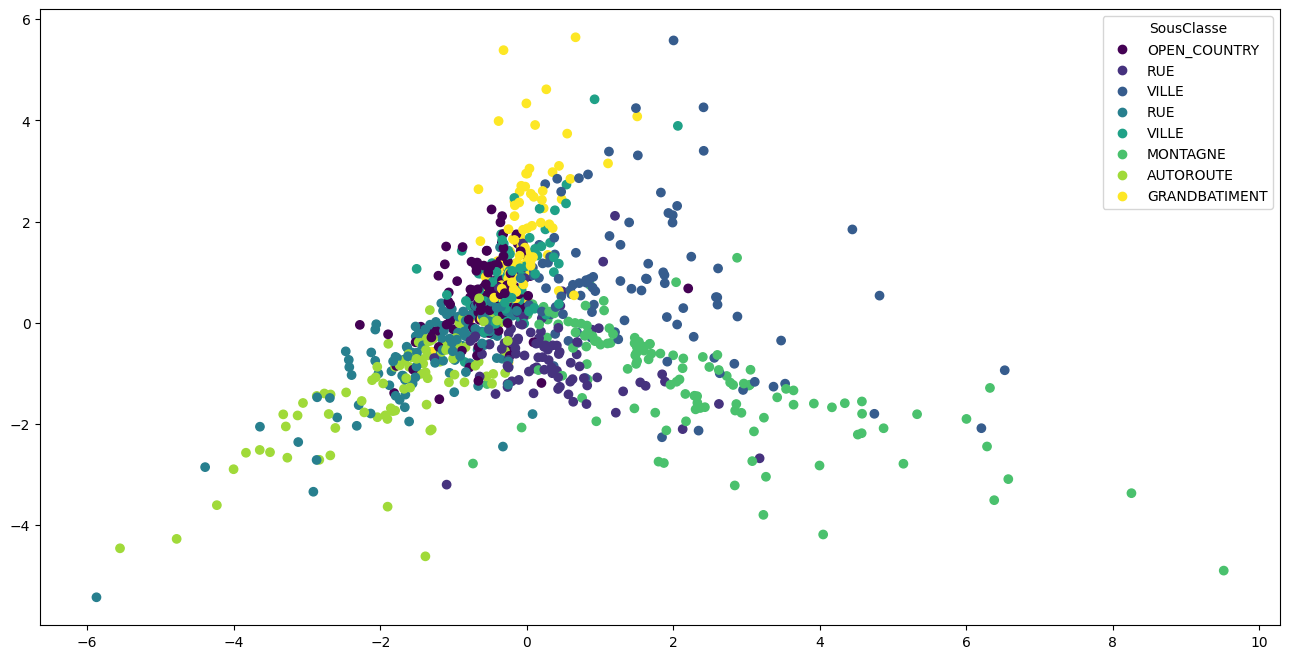

In [12]:
plt.figure(figsize=(16,8));
scatter = plt.scatter(Xlda[:,0], Xlda[:,1], c=ytest);
plt.legend(handles=scatter.legend_elements()[0], labels=X["SousClasse"].to_list(), title="SousClasse");
plt.savefig(folder_path + "/adl.png")

In [13]:
pca = PCA()
Xpca = pca.fit_transform(Xtest,ytest)
print(pca.explained_variance_ratio_)

[0.34702301 0.10743652 0.09349413 0.07704387 0.06813727 0.05561707
 0.03629023 0.03097346 0.02671735 0.01949775 0.01816784 0.01659756
 0.01585789 0.01459322 0.01166466 0.00976398 0.00965542 0.00863978
 0.00672012 0.00602654 0.0046144  0.00387037 0.00352958 0.00281529
 0.00220666 0.00167893 0.0013671 ]


/var/folders/rk/dysxg_n95dj298tmpfpz545r0000gn/T/ipykernel_11131/3444768928.py:3: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 2688
  plt.legend(handles=scatter.legend_elements()[0], labels=X["SousClasse"].to_list(), title="SousClasse");


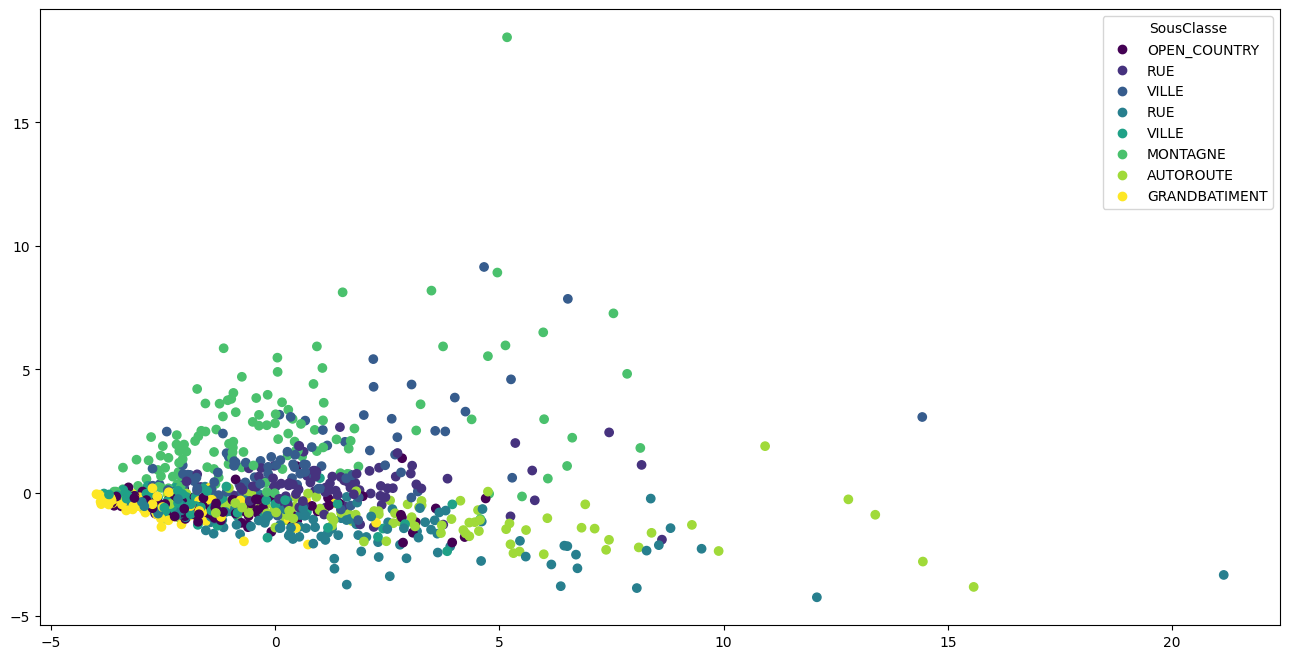

In [14]:
plt.figure(figsize=(16,8));
scatter = plt.scatter(Xpca[:,0], Xpca[:,1], c=ytest);
plt.legend(handles=scatter.legend_elements()[0], labels=X["SousClasse"].to_list(), title="SousClasse");
plt.savefig(folder_path + "/pca.png")

# MLP

In [15]:
acc = []
for i in range(7,17):
  mlp = MLPClassifier(hidden_layer_sizes=i, random_state=1, max_iter=500)
  Xpredmlp = cross_val_predict(mlp, Xtrain, ytrain, cv = 10)
  a = balanced_accuracy_score(y_true=ytrain, y_pred=Xpredmlp)
  acc.append(a)

/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multi

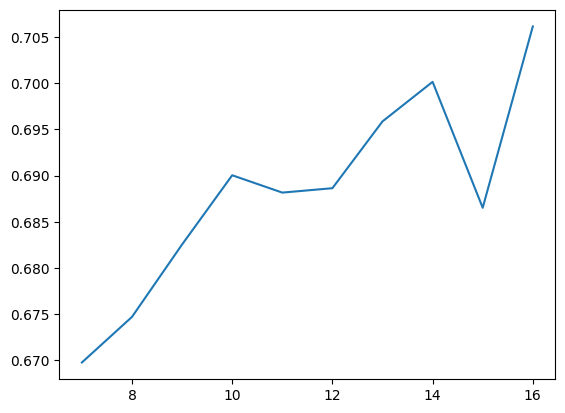

In [16]:
plt.plot(range(7,17), acc)